### Dataset descargado desde
## https://ieee-dataport.org/documents/smart-defender-dataset

La descripción de los campos que componen los datos del dataset están disponible en esa URL

# PARTE 1: Uso de Spark para análisis de datos, Dataframes #

In [1]:
# Mostrar la versión de Spark usada

# Datos de la sesión spark
spark

In [2]:
import pandas as pd
import matplotlib as plt

In [3]:
# Cargar el dataset en un Dataframe
smartDefender = spark.read.csv('../data/dataset_descriptor.csv', mode="DROPMALFORMED",inferSchema=True, header=True)

In [4]:
# Mostrar el schema heredado
smartDefender.printSchema()

root
 |-- ip_proto: double (nullable = true)
 |-- ip_len_mean: double (nullable = true)
 |-- ip_len_median: double (nullable = true)
 |-- ip_len_var: double (nullable = true)
 |-- ip_len_std: double (nullable = true)
 |-- ip_len_entropy: double (nullable = true)
 |-- ip_len_cv: double (nullable = true)
 |-- ip_len_cvq: double (nullable = true)
 |-- ip_len_rte: double (nullable = true)
 |-- ip_ttl_mean: double (nullable = true)
 |-- ip_ttl_median: double (nullable = true)
 |-- ip_ttl_var: double (nullable = true)
 |-- ip_ttl_std: double (nullable = true)
 |-- ip_ttl_entropy: double (nullable = true)
 |-- ip_ttl_cv: double (nullable = true)
 |-- ip_ttl_cvq: double (nullable = true)
 |-- ip_ttl_rte: double (nullable = true)
 |-- sport_mean: double (nullable = true)
 |-- sport_median: double (nullable = true)
 |-- sport_var: double (nullable = true)
 |-- sport_std: double (nullable = true)
 |-- sport_entropy: double (nullable = true)
 |-- sport_cv: double (nullable = true)
 |-- sport_cvq: 

In [5]:
# Mostrar el número de registros del dataset
total_reg = smartDefender.count()
total_reg

45500

In [6]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?
smartDefender.select('Label1').distinct().show()

+-----------------+
|           Label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|    tcp_fin_flood|
|  http_slow_range|
|           normal|
|        udp_flood|
|   http_slow_read|
|tcp_syn_ack_flood|
|    tcp_syn_flood|
|    tcp_ack_flood|
|http_slow_headers|
+-----------------+



In [7]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?
smartDefender.select('Label3').distinct().show()

+----------+
|    Label3|
+----------+
|http_flood|
| tcp_flood|
|    normal|
| udp_flood|
| http_slow|
+----------+



In [8]:
#Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.
anomalousSmartDefender = smartDefender.filter(smartDefender['Label3'] != 'normal')
print(round(anomalousSmartDefender.count() / smartDefender.count() * 100, 2), '%')

49.26 %


In [9]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico 
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcentajes (bar plot)
grouped_label3 = smartDefender.groupBy('Label3').count()
traffic_percentage = grouped_label3.select(grouped_label3['Label3'].alias('traffic'), (grouped_label3['count']/total_reg * 100).alias('percentage')).toPandas()

In [10]:
traffic_percentage

,traffic,percentage
0,http_flood,0.762637
1,tcp_flood,32.940659
2,normal,50.742857
3,udp_flood,15.151648
4,http_slow,0.402198


In [11]:
traffic_percentage.plot(kind="bar", x="traffic")

In [12]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir 
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

fileDataTransformed = smartDefender.withColumn('ip_proto_int', smartDefender.ip_proto * 1000)
fileDataTransformed.select('ip_proto_int').distinct().show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [13]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) 
# de bytes transmitidos agrupados por protocolo
fileDataTransformed.groupBy('ip_proto_int').sum('ip_len_mean').show()

+------------+-----------------+
|ip_proto_int| sum(ip_len_mean)|
+------------+-----------------+
|        17.0|7064.346040678178|
|         6.0| 26867.1914740567|
+------------+-----------------+



In [14]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
UDPSmartDefender = smartDefender.filter(smartDefender.ip_proto * 1000 == 17)
UDPSmartDefender.groupBy('Label1').sum('ip_len_mean').orderBy('sum(ip_len_mean)', ascending=False).show()

+---------+------------------+
|   Label1|  sum(ip_len_mean)|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



In [15]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
TCPSmartDefender = smartDefender.filter(smartDefender.ip_proto * 1000 == 6)
TCPSmartDefender.groupBy('Label1').sum('ip_len_mean').orderBy('sum(ip_len_mean)', ascending=False).show()

+-----------------+------------------+
|           Label1|  sum(ip_len_mean)|
+-----------------+------------------+
|           normal|11615.053998509025|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_fin_flood|            2000.0|
|    tcp_ack_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



# PARTE 2: Uso de Spark para análisis de datos, Spark SQL #

Contestar a las cuestiones anteriores empleando Spark SQL

In [16]:
# Crear la vista en memoria y añadir una celda por cada cuestión que se debe responder
smartDefender.createOrReplaceTempView("smartDefender")

In [17]:
# Q1. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label1?
spark.sql("SELECT DISTINCT Label1 FROM smartDefender").show()

+-----------------+
|           Label1|
+-----------------+
|       http_flood|
|   http_slow_body|
|    tcp_fin_flood|
|  http_slow_range|
|           normal|
|        udp_flood|
|   http_slow_read|
|tcp_syn_ack_flood|
|    tcp_syn_flood|
|    tcp_ack_flood|
|http_slow_headers|
+-----------------+



In [18]:
# Q2. ¿Cuantas clases de tipo de tráfico hay clasificadas en el campo label3?
spark.sql("SELECT DISTINCT Label3 FROM smartDefender").show()

+----------+
|    Label3|
+----------+
|http_flood|
| tcp_flood|
|    normal|
| udp_flood|
| http_slow|
+----------+



In [28]:
#Q3 ¿Que porcentaje de tráfico está catalogado como anormal? Entiendase por anormal aquel que no está etiquetado como normal.
spark.sql("SELECT CONCAT(ROUND((COUNT(*) / 45500) * 100, 2), ' %') as percentage  FROM smartDefender WHERE Label1 not like 'normal'").show()

+----------+
|percentage|
+----------+
|   49.26 %|
+----------+



In [29]:
# Q4 Mostrar los porcentajes de trafico sobre el total asociados a cada tipo de etiqueta de tráfico 
# (usar el campo genérico Label3 y no el detallado Label 1)
# Mostrar un diagrama con estos porcentajes (bar plot)
traf_perc = spark.sql("SELECT Label3 as traffic, (COUNT(*) / 45500) * 100 as percentage  FROM smartDefender GROUP BY Label3")
traf_perc.show()

+----------+-------------------+
|   traffic|         percentage|
+----------+-------------------+
|http_flood| 0.7626373626373626|
| tcp_flood|  32.94065934065934|
|    normal|  50.74285714285715|
| udp_flood| 15.151648351648353|
| http_slow|0.40219780219780216|
+----------+-------------------+



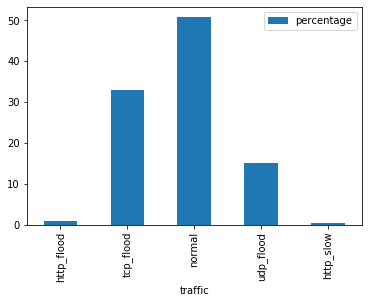

In [30]:
traf_perc.toPandas().plot(kind="bar", x="traffic")

In [31]:
# Q5 Identificar que tipo de tráfico de red está incluido en el dataset (usar el campo ip_proto y convertir 
# ese valor al real que debería tener, es decir, un entero en el rango definido por el IANA)
# https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml
iana = spark.sql("select distinct(ip_proto * 1000) as ip_proto_int FROM smartDefender")
iana.show()

+------------+
|ip_proto_int|
+------------+
|        17.0|
|         6.0|
+------------+



In [32]:
# Q6 Calcular la cantidad total (suponer que el dato a aculumar para cada paquete es ip_len_mean) 
# de bytes transmitidos agrupados por protocolo
spark.sql("select (ip_proto * 1000) as ip_proto_int, sum(ip_len_mean) from smartDefender group by ip_proto").show()

+------------+-----------------+
|ip_proto_int| sum(ip_len_mean)|
+------------+-----------------+
|        17.0|7064.346040678178|
|         6.0| 26867.1914740567|
+------------+-----------------+



In [35]:
# Q7 Indicar cual es tráfico anómalo en UDP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
spark.sql("select Label1, sum(ip_len_mean) as sum_ip_len_mean from smartDefender where ip_proto = 0.017 group by Label1 order by sum_ip_len_mean desc").show()

+---------+------------------+
|   Label1|   sum_ip_len_mean|
+---------+------------------+
|udp_flood|            6894.0|
|   normal|170.34604067817844|
+---------+------------------+



In [36]:
# Q8 Indicar cual es tráfico anómalo en TCP que usa más tráfico de red. Presentar los resultados en orden demayor a menor
spark.sql("select Label1, sum(ip_len_mean) as sum_ip_len_mean from smartDefender where ip_proto = 0.006 group by Label1 order by sum_ip_len_mean desc").show()

+-----------------+------------------+
|           Label1|   sum_ip_len_mean|
+-----------------+------------------+
|           normal|11615.053998509025|
|    tcp_syn_flood| 5713.195544936026|
|tcp_syn_ack_flood| 5273.157952268173|
|    tcp_fin_flood|            2000.0|
|    tcp_ack_flood|            2000.0|
|       http_flood| 90.88054677859463|
|  http_slow_range| 44.20993791090954|
|http_slow_headers|44.157370741482964|
|   http_slow_read|43.283366733466934|
|   http_slow_body|43.252756179024715|
+-----------------+------------------+



## Conclusiones de realización de la TP2

Me ha parecido una buena práctica para romper mano con spark. Me ha parecido muy bien guiada así como sencilla a la vez que útil. Sin embargo, he echado en falta que se hablara de las distintas versiones de Java de las que puedo hacer uso ya que he estado muy detenido por un error por culpa de tener Java 11 en lugar de Java 8.

Por el resto, muy contento con la realización de la práctica.

Un saludo.